In [1]:
import numpy as np
import pickle
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns
import colorcet as cc
from pathlib import Path
import sys

sys.path.append('../')

from visualization_utils import *
from utils import *

In [2]:
data_path = '../data/neuronal_data/'
gmm_path = '../data/ari_neuronal/'
figure_path = 'figures/neuronal/'

In [3]:
df_neurons = pd.read_pickle(Path(data_path, 'df_neuron.pkl'))

In [4]:
n_clusters = 20

In [5]:
latents = np.stack(df_neurons.latent_emb.values)
predictions = np.load(Path(gmm_path, f'best_preds_nc{n_clusters}.npy'))
cluster_means = np.load(Path(gmm_path, f'best_means_nc{n_clusters}.npy'))

In [6]:
with open(Path(data_path, 'tsne_embedding.sav'), 'rb') as f:
    tsne_emb = pickle.load(f)

In [7]:
tsne_cluster_means = tsne_emb.transform(cluster_means)

#### Retrieve 3-nearest neighbors with thresholding

In [8]:
knn_all_to_all = kneighbors_graph(
    cluster_means, 19, mode='distance', include_self=False
).toarray()
knn_all_to_all_sorted = np.sort(knn_all_to_all)

In [9]:
knn_all_to_all_sorted.mean(axis=0)[3]

2.3829275822575573

In [10]:
knn_dict = get_knn_dict(
    cluster_means, k=3, thresh=knn_all_to_all_sorted.mean(axis=0)[3]
)

### Plot

In [11]:
greys = np.linspace(0.2, 0.8, num=20)
norm = mpl.colors.Normalize(vmin=0.0028, vmax=0.048)

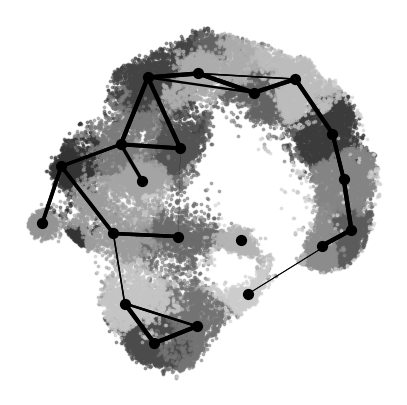

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for l in range(n_clusters):
    ax.scatter(
        *tsne_emb[predictions == l].T,
        s=3,
        color=str(greys[l]),
        alpha=0.5,
        rasterized=True,
        zorder=1
    )
    ax.scatter(
        tsne_cluster_means[l, 0],
        tsne_cluster_means[l, 1],
        s=50,
        color='black',
        alpha=1.0,
        zorder=3,
    )

    n = len(knn_dict[l])
    for i in range(n):
        d, idx = get_lines(l, cluster_means, latents, predictions, knn_dict, neigh=i)

        ax.plot(
            [tsne_cluster_means[l, 0], tsne_cluster_means[idx, 0]],
            [tsne_cluster_means[l, 1], tsne_cluster_means[idx, 1]],
            linewidth=(norm(d) - 1) * -3 + 0.1,
            color='black',
            alpha=1.0,
            zorder=2,
        )

ax.axis('off');
# fig.savefig(Path(figure_path, 'tsne_neurons_nearest_neighbor.pdf'), bbox_inches='tight', transparent=True)